<a href="https://colab.research.google.com/github/haedongmu/AIFFEL_quest_cr/blob/main/Project/Dataton_age.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#구글드라이브 마운트하기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#데이터셋 읽기
import pandas as pd
file_name_list = ['netflix_titles', 'disney_plus_titles', 'amazon_prime_titles']
root_path = '/content/drive/My Drive/아이펠/'
file_ext = 'csv'
# 여러 파일을 읽어서 하나의 데이터프레임으로 합치기
dataframes = []  # 데이터를 저장할 리스트

for file_name in file_name_list:
    file_path = f"{root_path}{file_name}.{file_ext}"  # 경로 생성
    df = pd.read_csv(file_path)  # CSV 파일 읽기

    # 파일명을 가공해 새로운 필드 추가
    platform_name = file_name.split('_titles')[0]  # '_titles' 앞부분 추출
    df['platform'] = platform_name  # 새로운 열 추가

    # 필요한 열만 선택하고 순서 정렬
    df = df[['platform', 'country', 'listed_in', 'rating']]

    dataframes.append(df)  # 리스트에 추가

# 데이터프레임 결합
combined_data = pd.concat(dataframes, ignore_index=True)

# 결과 확인
from tabulate import tabulate
print(tabulate(combined_data.head(), headers='keys', tablefmt='grid'))

print(len(combined_data))

+----+------------+---------------+---------------------------------------------------------------+----------+
|    | platform   | country       | listed_in                                                     | rating   |
+====+============+===============+===============================================================+==========+
|  0 | netflix    | United States | Documentaries                                                 | PG-13    |
+----+------------+---------------+---------------------------------------------------------------+----------+
|  1 | netflix    | South Africa  | International TV Shows, TV Dramas, TV Mysteries               | TV-MA    |
+----+------------+---------------+---------------------------------------------------------------+----------+
|  2 | netflix    | nan           | Crime TV Shows, International TV Shows, TV Action & Adventure | TV-MA    |
+----+------------+---------------+---------------------------------------------------------------+----------+
|

In [ ]:
# 결측치 제거: 'country', 'listed_in', 'rating' 필드 중 하나라도 결측치가 있으면 삭제
combined_data = combined_data.dropna(subset=['country', 'listed_in', 'rating'])

# 결과 확인
from tabulate import tabulate
print(tabulate(combined_data.head(), headers='keys', tablefmt='grid'))
print(combined_data.shape)

+----+------------+-----------------------------------------------------------------------+--------------------------------------------------------+----------+
|    | platform   | country                                                               | listed_in                                              | rating   |
+====+============+=======================================================================+========================================================+==========+
|  0 | netflix    | United States                                                         | Documentaries                                          | PG-13    |
+----+------------+-----------------------------------------------------------------------+--------------------------------------------------------+----------+
|  1 | netflix    | South Africa                                                          | International TV Shows, TV Dramas, TV Mysteries        | TV-MA    |
+----+------------+---------------------

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import difflib
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

# WordNetLemmatizer 초기화
lemmatizer = WordNetLemmatizer()

# 유사한 장르를 그룹화하는 함수
def group_similar_genres(genres, threshold=0.8):
    unique_genres = list(set(genres))  # 고유한 장르 목록
    grouped_genres = {}

    for genre in unique_genres:
        # 복수형을 단수형으로 변환
        genre_singular = lemmatizer.lemmatize(genre.lower())
        matched = False
        for key in grouped_genres:
            # 유사도 계산 (difflib)
            similarity = difflib.SequenceMatcher(None, genre_singular, key.lower()).ratio()
            if similarity >= threshold:
                grouped_genres[key].append(genre)
                matched = True
                break
        if not matched:
            grouped_genres[genre_singular] = [genre]

    # 그룹화된 결과 반환
    return grouped_genres

# 원핫 인코딩 열을 만들 때, 그룹화된 필드명에 대해 원핫 인코딩을 적용
def generate_one_hot_encoding(df, grouped_fields):
    unique_field_groups = list(grouped_fields.keys())

    # 원핫 인코딩 열 생성
    for field_group in unique_field_groups:
        column_name = f'genre_{field_group.replace(" ", "_")}'
        df[column_name] = df['genres'].apply(
            lambda x: 1 if any(g.lower() in map(str.lower, grouped_fields[field_group]) for g in x) else 0
        )

    return df

In [ ]:
#1. 장르명 그룹화
combined_data['genres'] = combined_data['listed_in'].apply(lambda x: x.split(', ') if pd.notna(x) else [])

# 장르 목록을 combined_data에서 가져오는 예시 (combined_data['genres']에 장르 목록이 있다고 가정)
all_genres = [genre for genres in combined_data['genres'] for genre in genres]

# 유사한 장르명 그룹화
grouped_genres = group_similar_genres(all_genres, threshold=0.8)

gropped_data = combined_data.copy()

# 원본 데이터프레임에서 원핫 인코딩 적용
gropped_data = generate_one_hot_encoding(gropped_data, grouped_genres)


#2. 국가명 그룹화
gropped_data['make_country'] = gropped_data['country'].apply(lambda x: x.split(',') if pd.notna(x) else [])

# 원본 데이터프레임에서 원핫 인코딩 적용
from sklearn.preprocessing import MultiLabelBinarizer

# 원본 데이터프레임 복사
gropped_data_copy = gropped_data.copy()

# MultiLabelBinarizer 초기화
mlb = MultiLabelBinarizer()

# 원핫 인코딩 적용(국가명은 알파벳 순서로 정렬됨)
country_one_hot = pd.DataFrame(mlb.fit_transform(gropped_data_copy['make_country']),
                               columns=mlb.classes_,
                               index=gropped_data_copy.index)

# 원핫 인코딩 데이터프레임을 복사본 데이터프레임과 결합
gropped_data = pd.concat([gropped_data_copy, country_one_hot], axis=1)

#3. 시청등급 기준 그룹화
# 3. 시청등급 기준 그룹화 (숫자 min 패턴 제외)
import re
# rating 필드에서 '숫자 min' 패턴 제거
def is_valid_rating(rating):
    if pd.isna(rating):  # NaN 처리
        return False
    return not re.match(r'^\d+\s*min$', str(rating))

# 유효한 rating만 남기기
gropped_data['filtered_rating'] = gropped_data['rating'].apply(lambda x: x if is_valid_rating(x) else None)

# 'filtered_rating' 필드를 리스트로 변환
gropped_data['rating_list'] = gropped_data['filtered_rating'].apply(lambda x: [x] if pd.notna(x) else [])

# MultiLabelBinarizer 초기화
mlb_rating = MultiLabelBinarizer()

# 'rating_list'에 대해 원핫 인코딩 적용
rating_one_hot = pd.DataFrame(
    mlb_rating.fit_transform(gropped_data['rating_list']),
    columns=mlb_rating.classes_,
    index=gropped_data.index
)

# 원핫 인코딩 결과를 데이터프레임에 병합
gropped_data = pd.concat([gropped_data, rating_one_hot], axis=1)

# 결과 확인
print("원핫 인코딩된 데이터프레임:")
print(tabulate(gropped_data.head(), headers='keys', tablefmt='grid'))
print(f"데이터프레임 크기: {gropped_data.shape}")



원핫 인코딩된 데이터프레임:
+----+------------+-----------------------------------------------------------------------+--------------------------------------------------------+----------+----------------------------------------------------------------+----------------------+-------------------+---------------+--------------------+----------------+---------------+-------------+------------------------------+----------------------------------+---------------+--------------------------+---------------+--------------------+------------------------+-----------------+-------------------------+------------------+----------------+--------------------+----------------+------------------+--------------------+------------------------------+---------------+-------------------------------+---------------------------+-------------------------+--------------------------------+---------------------+-------------------------+-----------------------------+-----------------------+------------------+-----------------

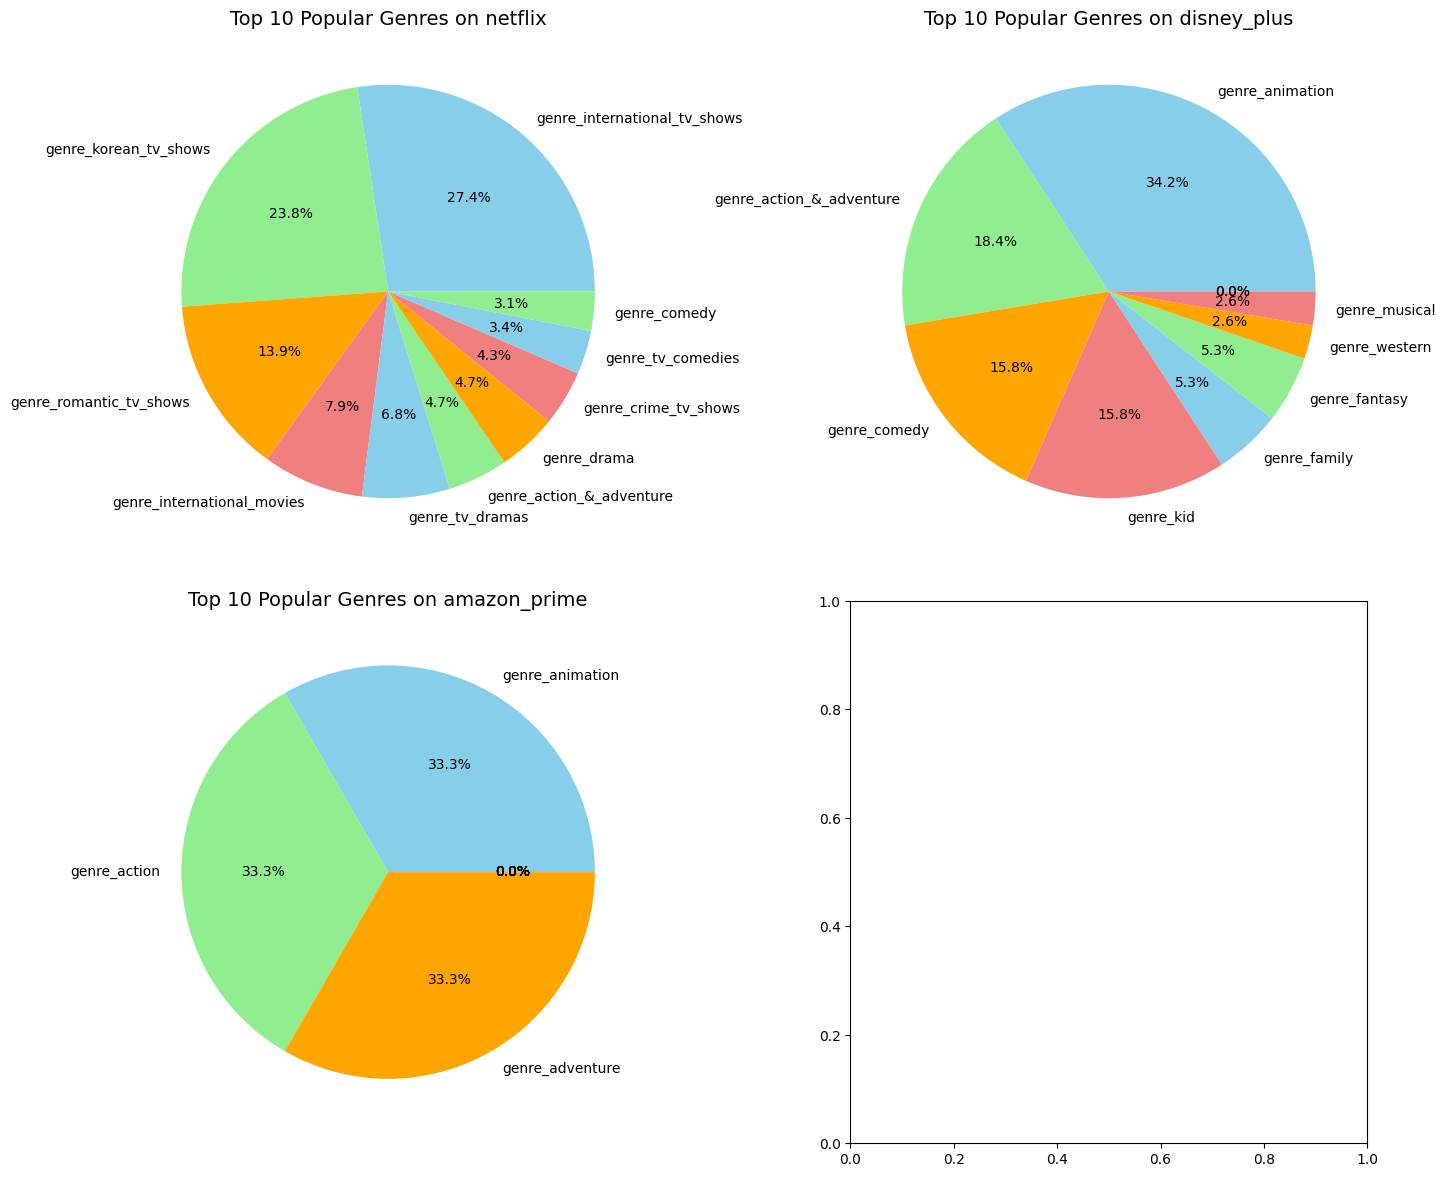

In [ ]:
#각 플랫폼별로 한국콘텐츠 중 인기있는 장르 분석

import matplotlib.pyplot as plt

# 1. 한국 콘텐츠만 필터링 (country에 'South Korea' 포함)
korean_content_data = gropped_data[gropped_data['country'].str.contains('South Korea', na=False)]

# 2. 플랫폼 목록 추출
platforms = korean_content_data['platform'].unique()

# 3. 각 플랫폼에 대해 상위 4개 장르 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

top_ranking = 10
# 4. 각 플랫폼에 대해 서브플롯에 차트 추가
for i, platform in enumerate(platforms):
    # 각 서브플롯 위치
    ax = axes[i // 2, i % 2]  # 2x2 배열로 서브플롯 배치
    platform_data = korean_content_data[korean_content_data['platform'] == platform]

    # 5. 장르를 나타내는 'genre_'로 시작하는 컬럼을 필터링
    genre_columns = [col for col in platform_data.columns if col.startswith('genre_')]

    # 6. 각 장르에 대해 1인 값만 추출하여 해당 장르가 포함된 콘텐츠 카운트
    genre_counts = platform_data[genre_columns].sum()

    # 7. 상위 4개 장르 추출
    top_4_genres = genre_counts.sort_values(ascending=False).head(top_ranking)

    # 8. 파이 차트 시각화
    top_4_genres.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'orange', 'lightcoral'], ax=ax)
    ax.set_title(f'Top {top_ranking} Popular Genres on {platform}', fontsize=14)
    ax.set_ylabel('')  # y축 레이블 제거

# 9. 레이아웃 조정
plt.tight_layout()
plt.show()


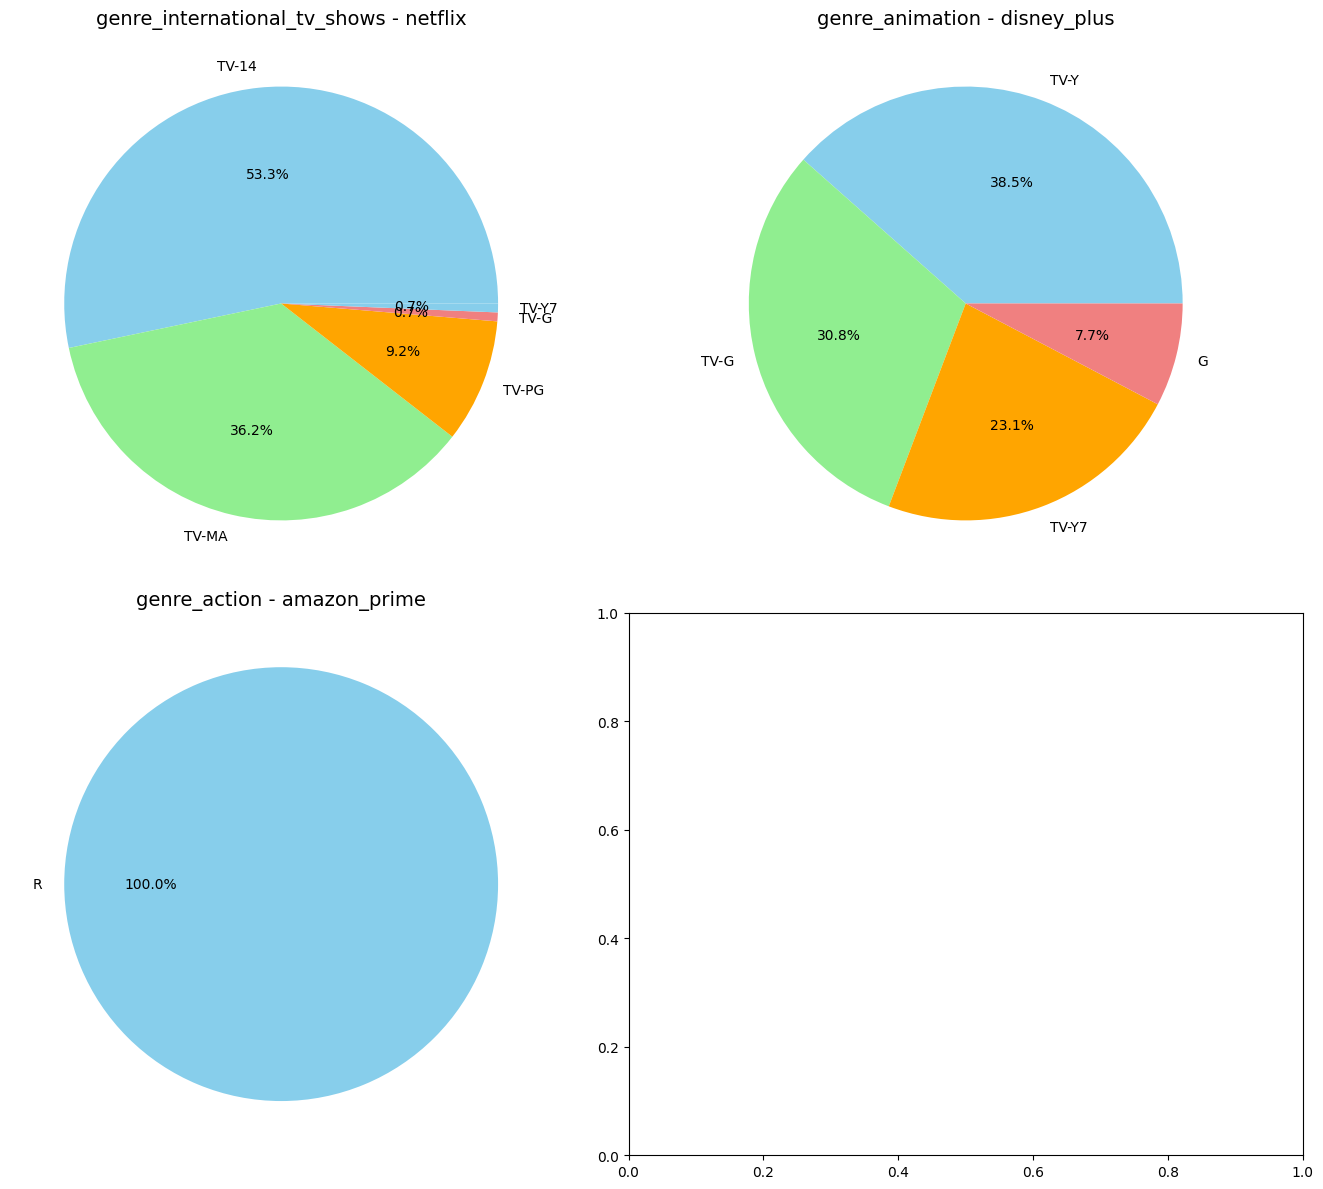

In [ ]:
#각 플랫폼별로 가장 인기 있는 한국 콘텐츠에 대한 연령분포 분석

import matplotlib.pyplot as plt

# 1. 한국 콘텐츠만 필터링 (country에 'South Korea' 포함)
korean_content_data = gropped_data[gropped_data['country'].str.contains('South Korea', na=False)]

# 2. 플랫폼 목록 추출
platforms = korean_content_data['platform'].unique()

# 3. 각 플랫폼에 대해 가장 인기 있는 장르 선정 및 연령 등급 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 4. 각 플랫폼에 대해 서브플롯에 차트 추가
for i, platform in enumerate(platforms):
    # 각 서브플롯 위치
    ax = axes[i // 2, i % 2]  # 2x2 배열로 서브플롯 배치
    platform_data = korean_content_data[korean_content_data['platform'] == platform]

    # 5. 장르를 나타내는 'genre_'로 시작하는 컬럼을 필터링
    genre_columns = [col for col in platform_data.columns if col.startswith('genre_')]

    # 6. 각 장르에 대해 1인 값만 추출하여 해당 장르가 포함된 콘텐츠 카운트
    genre_counts = platform_data[genre_columns].sum()

    # 7. 가장 인기 있는 장르 선정 (가장 많이 포함된 장르)
    most_popular_genre = genre_counts.idxmax()

    # 8. 가장 인기 있는 장르의 콘텐츠 추출
    popular_genre_data = platform_data[platform_data[most_popular_genre] == 1]

    # 9. 연령 등급 분포 계산
    rating_counts = popular_genre_data['rating'].value_counts()

    # 10. 파이 차트 시각화
    explode = [0.1 if label == most_popular_genre else 0 for label in rating_counts.index]  # 인기 장르 강조
    rating_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'orange', 'lightcoral'],
                       ax=ax, explode=explode)

    # 간단한 타이틀로 수정
    ax.set_title(f'{most_popular_genre} - {platform}', fontsize=14)
    ax.set_ylabel('')  # y축 레이블 제거

# 11. 레이아웃 조정
plt.tight_layout()
plt.show()



